In [1]:
import sunpy
import numpy as np
import matplotlib.pyplot as plt
import time
from std_pixel_to_world import std_pixel_to_world
from sunpy.image.resample import resample

from aiapy.calibrate import register, update_pointing,normalize_exposure,correct_degradation
from aiapy.psf import deconvolve

## level 1.5 processing
https://aiapy.readthedocs.io/en/stable/preparing_data.html

In [3]:
aia_filename = "../data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits"
smap = sunpy.map.Map(aia_filename)
smap=deconvolve(smap, clip_negative=True,use_gpu=True)
smap=update_pointing(smap)
smap=register(smap)
smap=correct_degradation(smap)
adjusted_map=normalize_exposure(smap)

c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 22:58:56
Exposure Time,1.0 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

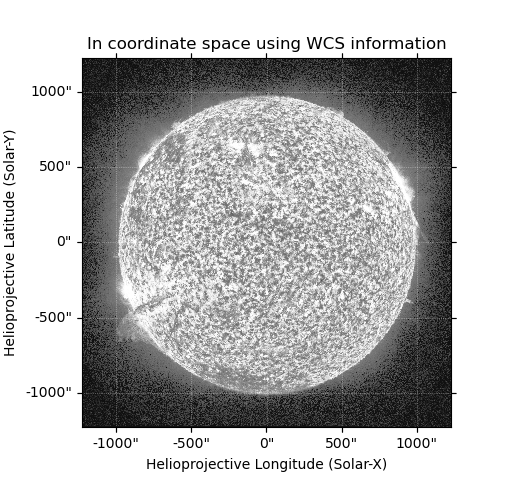
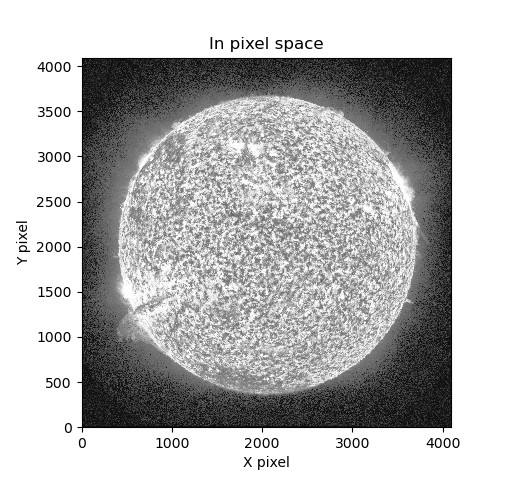
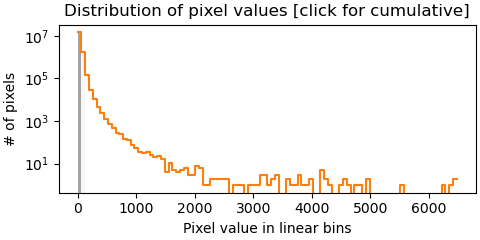
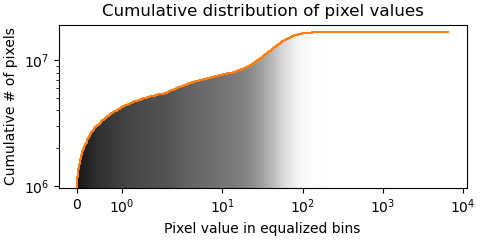

In [3]:
adjusted_map

In [7]:
newfile="../data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits"
adjusted_map.save(newfile, overwrite=True)

PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: '../data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits'

## pixel_to_world Matrix
AIA level 1.5 FOV is stable, so I just need to get the Tx,Ty of pixels in one image

In [2]:
newfile="../data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits"
adjusted_map=sunpy.map.Map(newfile)

In [3]:
std_pixel_to_world(2047.5, 2047.5)

(7.498798913309287e-33, 0.0)

In [5]:
# Construct a grid of pixel positions 
x_pixel = np.linspace(0, 4095, num=4096,endpoint=True)
y_pixel = np.linspace(0, 4095, num=4096,endpoint=True)
# X Y : pixel position array
X,Y=np.meshgrid(x_pixel,y_pixel)

In [6]:
X

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       ...,
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03]])

In [9]:
newshape=(128,128)
downsampled_X=resample(X,newshape,method='linear',center=False,minusone = False)
downsampled_Y=resample(Y,newshape,method='linear',center=False,minusone = False)

In [8]:
# Initialize angle array: Tx and Ty
downsampled_Tx=np.full(newshape,np.nan)
downsampled_Ty=np.full(newshape,np.nan)


for i in range(newshape[0]):
    for j in range(newshape[1]):
        downsampled_Tx[i,j],downsampled_Ty[i,j]=std_pixel_to_world(downsampled_X[i,j],downsampled_Y[i,j])

In [10]:
# tiny check, resample is reversible
full_shape=(4096,4096)
resample(downsampled_X,full_shape,method='linear',center=False,minusone = False)

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       ...,
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03]])

In [11]:
full_shape=(4096,4096)
Tx=resample(downsampled_Tx,full_shape,method='linear',center=False,minusone = False)
Ty=resample(downsampled_Ty,full_shape,method='linear',center=False,minusone = False)

## Check

In [12]:
aia_filename = "../data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits"
smap = sunpy.map.Map(aia_filename)

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 22:58:56
Exposure Time,1.0 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

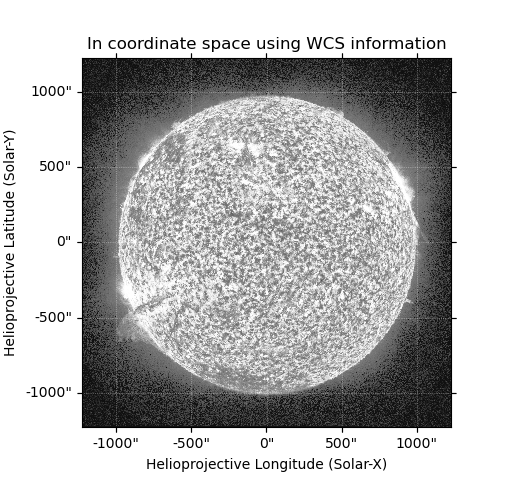
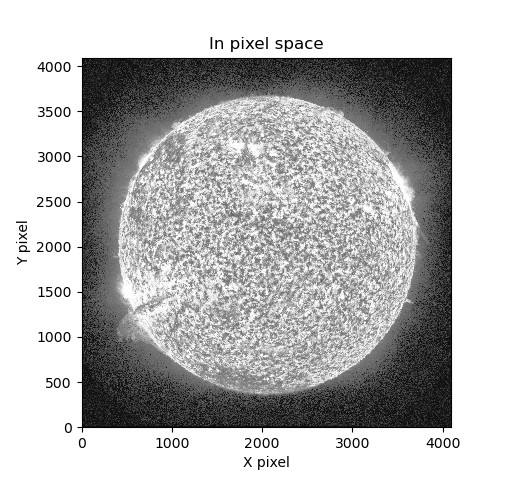
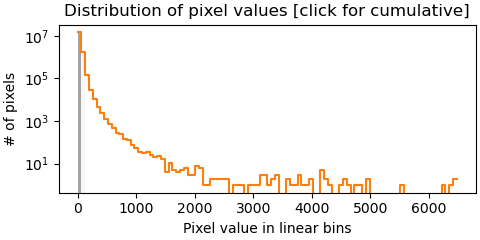
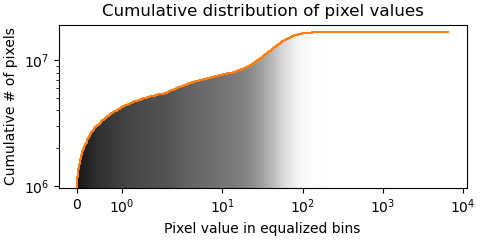

In [13]:
smap

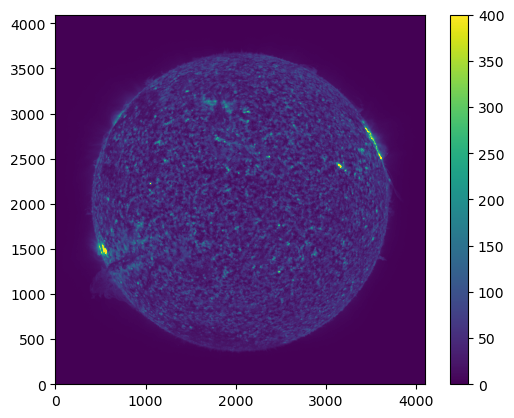

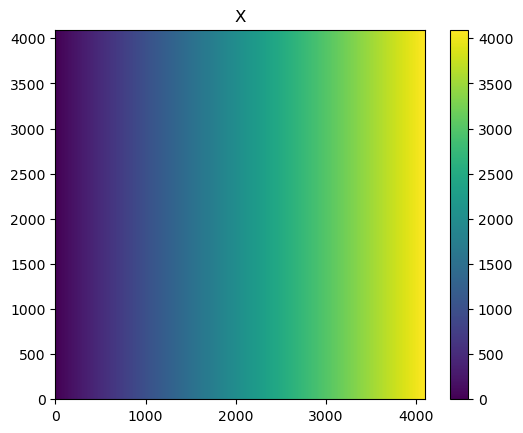

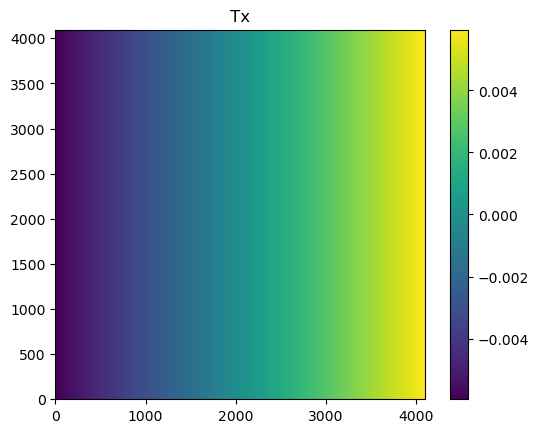

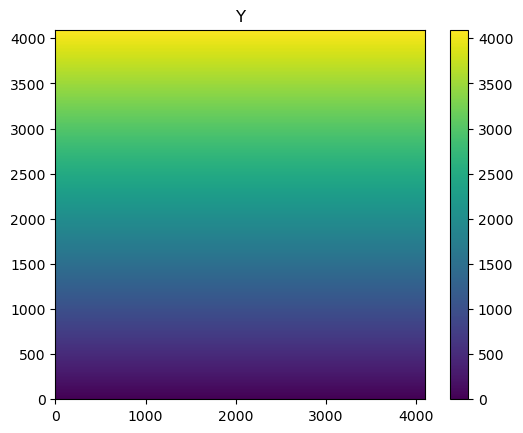

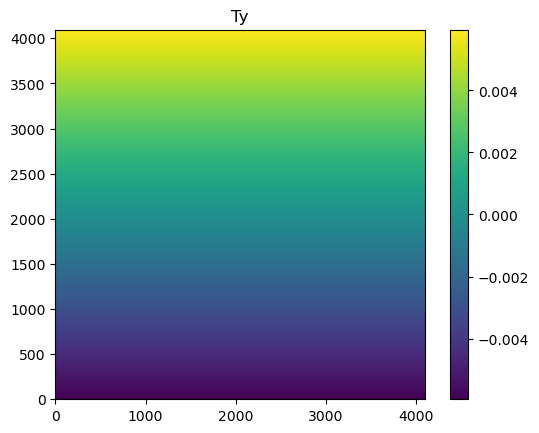

In [14]:
fig,ax=plt.subplots()
sc=ax.imshow(smap.data,vmax=400,origin='lower')
fig.colorbar(sc)

fig,ax=plt.subplots()
sc=ax.imshow(X,origin='lower')
ax.set_title('X')
fig.colorbar(sc)
fig,ax=plt.subplots()
sc=ax.imshow(Tx,origin='lower')
ax.set_title('Tx')
fig.colorbar(sc)

fig,ax=plt.subplots()
sc=ax.imshow(Y,origin='lower')
ax.set_title('Y')
fig.colorbar(sc)
fig,ax=plt.subplots()
sc=ax.imshow(Ty,origin='lower')
ax.set_title('Ty')
fig.colorbar(sc)


## save Tx and Ty into npz

### 4096

In [17]:
Tx_4096=Tx
Tx_4096.shape

(4096, 4096)

In [18]:
Ty_4096=Ty
Ty_4096.shape

(4096, 4096)

Text(0.5, 1.0, 'Y')

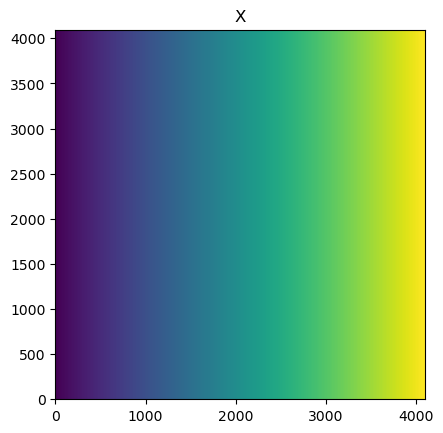

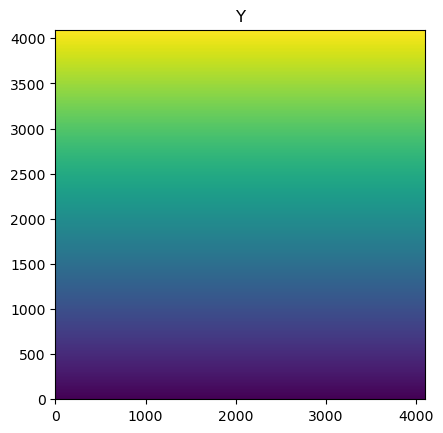

In [28]:
fig,ax=plt.subplots()
ax.imshow(Tx_4096,origin='lower')
ax.set_title('X')

fig,ax=plt.subplots()
ax.imshow(Ty_4096,origin='lower')
ax.set_title('Y')


### 2048

In [19]:
shape_2048=(2048,2048)
Tx_2048=resample(Tx_4096,shape_2048,method='linear',center=False,minusone = False)
Ty_2048=resample(Ty_4096,shape_2048,method='linear',center=False,minusone = False)

Text(0.5, 1.0, 'Y')

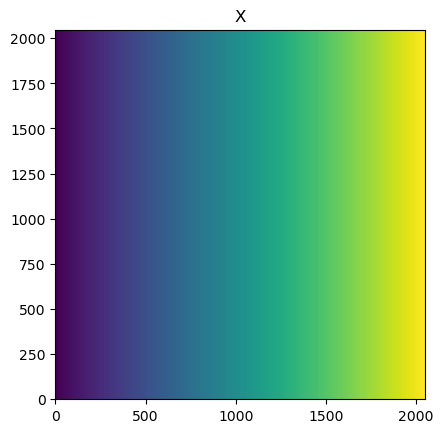

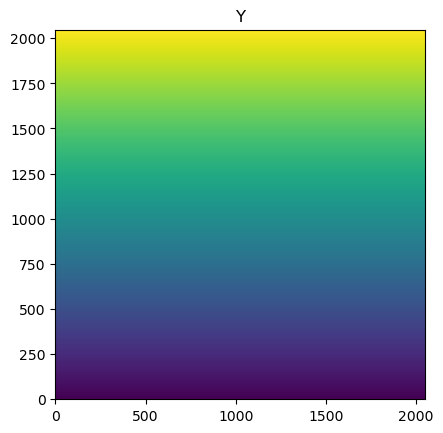

In [29]:
fig,ax=plt.subplots()
ax.imshow(Tx_2048,origin='lower')
ax.set_title('X')

fig,ax=plt.subplots()
ax.imshow(Ty_2048,origin='lower')
ax.set_title('Y')

## 1024

In [20]:
shape_1024=(1024,1024)
Tx_1024=resample(Tx_4096,shape_1024,method='linear',center=False,minusone = False)
Ty_1024=resample(Ty_4096,shape_1024,method='linear',center=False,minusone = False)

Text(0.5, 1.0, 'Y')

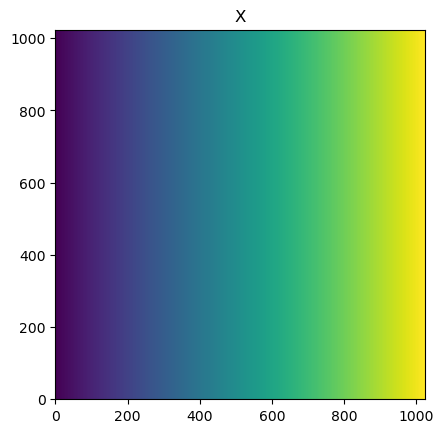

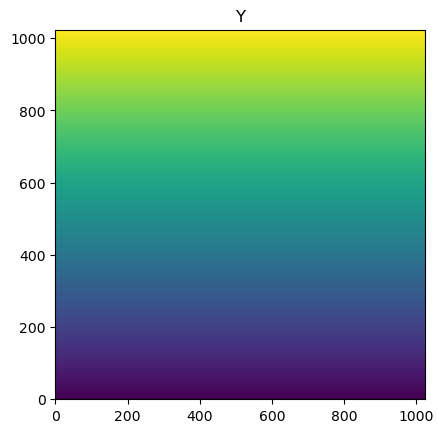

In [30]:
fig,ax=plt.subplots()
ax.imshow(Tx_1024,origin='lower')
ax.set_title('X')

fig,ax=plt.subplots()
ax.imshow(Ty_1024,origin='lower')
ax.set_title('Y')

In [31]:
file='coeff.npz'
np.savez(file, 
         Tx_4096=Tx_4096, Ty_4096=Ty_4096,
        Tx_2048=Tx_2048, Ty_2048=Ty_2048,
        Tx_1024=Tx_1024, Ty_1024=Ty_1024,
        )